<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#load-and-research-data" data-toc-modified-id="load-and-research-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load and research data</a></span></li><li><span><a href="#split-train-test" data-toc-modified-id="split-train-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>split train test</a></span></li><li><span><a href="#build-datasets" data-toc-modified-id="build-datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>build datasets</a></span></li><li><span><a href="#train-model" data-toc-modified-id="train-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>train model</a></span></li></ul></div>

In [51]:
import time
import pickle
import random
import librosa
from collections import Counter, defaultdict
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout, Conv1D, MaxPool1D, Flatten
from keras.utils import to_categorical

# load and research data

In [2]:
df = pd.read_csv('./data/data_v_7_stc/meta/fold1_train.txt', sep='\t')

In [3]:
df.columns = ['filename', 'xz1', 'xz2', 'time', 'target']

In [4]:
df.head(1)

,filename,xz1,xz2,time,target
0,background_0001_time_stretch_1.wav,office,0.0,9.87941,background


In [5]:
df['target'].value_counts()

door             2732
tool             1327
knocking_door    1324
bags              988
keyboard          980
background        899
ring              570
speech            220
Name: target, dtype: int64

In [7]:
df_train = df.sample(frac=0.9)
df_test = df[~df.index.isin(df_train.index)]

In [8]:
df_train['target'].value_counts()

door             2471
knocking_door    1197
tool             1169
bags              899
keyboard          879
background        809
ring              526
speech            186
Name: target, dtype: int64

In [11]:
targets_list = list(df['target'].unique())
targets_list.sort()
target2ind = {
    target: i
    for i, target in enumerate(targets_list)
}

# split train test

In [18]:
T = 8000 # sample size
F = 8000 # frequency

In [19]:
def build_target_samples(df_):
    target_samples = defaultdict(list) # target -> [sample1, sample2, ...]

#     t = time.time()
    for row_no, row in df_.iterrows():

#         if row_no % 100 == 0:
#             print(row_no, time.time() - t)
#             t = time.time()

        filename = './data/data_v_7_stc/audio/' + row['filename']
        data, rate = librosa.load(filename, sr=F)

        target = row['target']
        for i in range(0, data.shape[0] - T, T):
            sample = data[i: i + T]
            if sample.shape[0] < T:
                continue
            target_samples[target].append(sample)

    for target in target_samples.keys():
        random.shuffle(target_samples[target])

    return target_samples

In [17]:
test_target_samples = build_target_samples(df_test)

In [24]:
with open('./data/test_8000.pkl', 'wb') as f:
    f.write(pickle.dumps(test_target_samples))

In [22]:
train_target_samples = build_target_samples(df_train)

In [25]:
with open('./data/train_8000.pkl', 'wb') as f:
    f.write(pickle.dumps(train_target_samples))

# build datasets

In [26]:
with open('./data/test_8000.pkl', 'rb') as f:
    test_target_samples = pickle.loads(f.read())

In [27]:
with open('./data/train_8000.pkl', 'rb') as f:
    train_target_samples = pickle.loads(f.read())

In [36]:
def build_dataset(target_samples):
    min_n = None
    for target, samples in target_samples.items():
        if min_n is None or len(samples) < min_n:
            min_n = len(samples)
    
    x, y = [], []
    for target, samples in target_samples.items():
        x += samples[:min_n]
        y += [target2ind[target] for _ in range(min_n)]

    x = np.vstack(x)
    y = np.array(y)
    
    indices = list(range(x.shape[0]))
    random.shuffle(indices)

    x = x[indices]
    y = y[indices]
    
    return x, y

In [37]:
x_train, y_train = build_dataset(train_target_samples)
x_test, y_test = build_dataset(test_target_samples)

In [48]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# train model

In [53]:
model = Sequential()
model.add(Conv1D(128, 8, strides=2, input_shape=(8000, 1)))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(64, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(32, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(16, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
history = model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=20, validation_data=[x_test, to_categorical(y_test)])

Train on 27840 samples, validate on 2936 samples
Epoch 1/20
  992/27840 [>.............................] - ETA: 10:01 - loss: 1.9675 - acc: 0.1925

KeyboardInterrupt: 

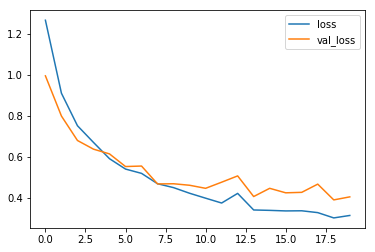

In [51]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

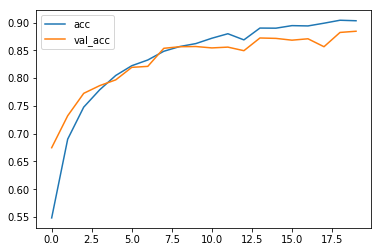

In [52]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [53]:
model.save('./data/baseline1.pkl')